# TSAI Exercise Sheet 8

## Intuition on DSR with PLRNNs

### What is a lower bound to the PLRNN dimension M required to reconstruct a dynamical system f with the following properties?

**$f$ diverges**: With dimension $M = 1$, we can reconstruct a dynamical system with divergence. For $M=1$ we have
$$x_{t+1} = a z_t + w \phi(z_t)+h$$
If for example $a,w,h>1$ we see divergence. 

**$f$ has a fixpoint**: Again $M=1$ is sufficient. We have previously (in lecture and in sheet 5) seen that the system above has a stable fixpoint for $|a|<1$ and $w = 0$. 

**$f$ has $m$ fixed points**: For $M = m$ we have:
$$x_t = a_{11}z_{t1} + \sum_{j=2}^m w_{1j}z_{tj} + h_1$$
Consider $\phi(z_{tj})$. Depending on whether $z_{tj}>0$ the slope of $z_{tj} \rightarrow x_t$ is either $0$ or $w_{1j}$. Having $M=m$ splits the state space into $m$ linear regions, allowing for $m$ different fixpoints.  

**$f$ has a cycle of order 2**:

**$f$ has a cycle of order $c>2$**:

**$f$ is chaotic**:

## Training on chaotic data

In [29]:
import numpy as np
import math
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F

from random import randint
from tqdm import trange

### Load the data using numpy.load and visualize it with a 3D plot

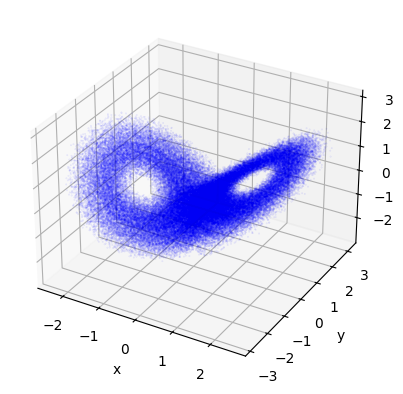

In [30]:
from mpl_toolkits.mplot3d import Axes3D

data = np.load("lorenz63_train.npy").astype(np.float32)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

x = data[:,0]
y = data[:,1]
z = data[:,2]

ax.scatter(x, y, z, c='blue', marker='o', alpha=0.1, s=0.1)

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

plt.show()

### Use the standard RNN, which you have already used for the last exercises, and try to reproduce the attractor.

In [31]:
%run standard_RNN.py

In [32]:
data_tensor = torch.tensor(data, dtype=torch.float32)
hidden_size = 200  

# Training parameters
epochs = 200
learning_rate = 0.001 

observation_size = data.shape[1]
print(f"Data shape: {data.shape}")
print(f"Observation size: {observation_size}")
print(f"Time steps: {data.shape[0]}")

# Initialize the model
model = LatentRNN(observation_size, hidden_size)
# Print model information
print(f"\nModel Architecture:")
print(f"- Observation dimension: {observation_size}")
print(f"- Hidden dimension: {hidden_size}")
print(f"- Total parameters: {sum(p.numel() for p in model.parameters())}")

alpha = 0.0005
def regul_l1(par):
    return(alpha * sum(p.abs().sum() for p in par))

# Train the model
losses = train(model, learning_rate = learning_rate, moment=0, optimizer_function='ADAM', epochs=epochs,
               print_loss=False, batch_size=32, batch_sequence_length=300, regul = regul_l1, data = data_tensor)

Data shape: (100000, 3)
Observation size: 3
Time steps: 100000

Model Architecture:
- Observation dimension: 3
- Hidden dimension: 200
- Total parameters: 41403

Starting training for 200 epochs...
Optimizer: ADAM, LR: 0.001, Batch size: 32, Sequence length: 300


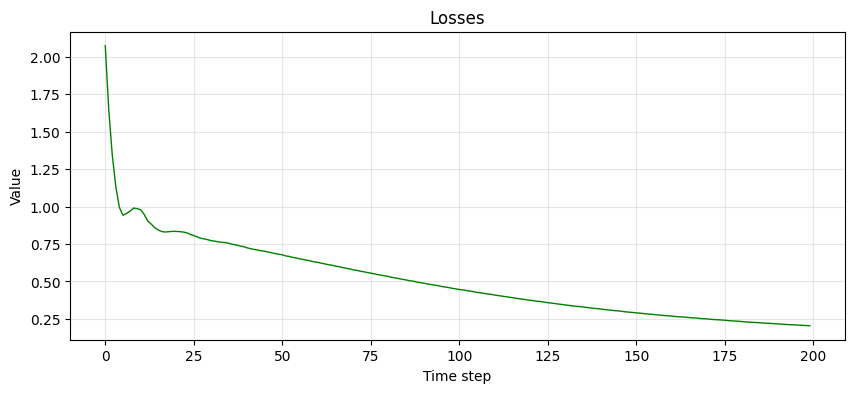

In [33]:
plt.figure(figsize=(10, 4))
plt.plot(losses, linewidth=1, c='green')
plt.xlabel('Time step')
plt.ylabel('Value')
plt.title('Losses')
plt.grid(True, alpha=0.3)
plt.show()

### Reconstructing the attractor

In [34]:
h0 = tc.zeros(1, 1, model.latent_dim)

input_seq = data_tensor[:-1].unsqueeze(1)  # (T-1, 1, obs_dim)
target_seq = data_tensor[1:].unsqueeze(1)  # (T-1, 1, obs_dim)

# Run the model
with tc.no_grad():
    output_seq, _ = model(input_seq, h0) 

mse_loss = nn.MSELoss()
mse = mse_loss(output_seq, target_seq).item()
print(f"Mean Squared Error on full sequence: {mse:.6f}")


Mean Squared Error on full sequence: 0.008583


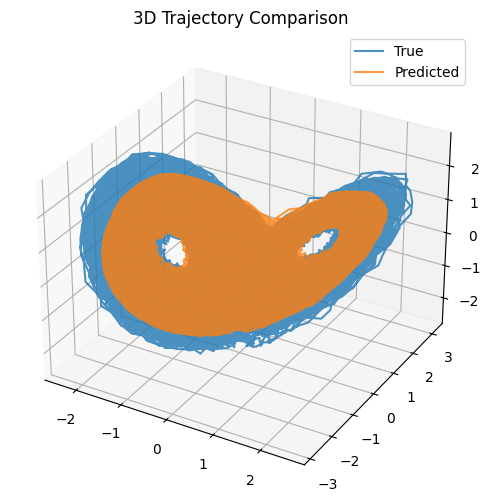

In [35]:
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111, projection='3d')

ax.plot(input_seq[:,:, 0], input_seq[:,:, 1], input_seq[:,:, 2], label='True', alpha = 0.8)
ax.plot(output_seq[:,:, 0], output_seq[:,:, 1], output_seq[:,:, 2], label='Predicted', alpha = 0.8)
ax.set_title("3D Trajectory Comparison")
ax.legend()
plt.show()

**How well does it work, judged by visual inspection and mean-squared error?**


okay I guess, but not great. Seems as if the regularization is too large? 

### Implement the piecewise-linear RNN

***Dataset***

In [104]:
class TimeSeriesDataset():
    def __init__(self, data, sequence_length=200, batch_size=16):
        self.X = torch.tensor(data, dtype=torch.float32)
        self.total_time_steps = self.X.shape[0]
        self.sequence_length = sequence_length
        self.batch_size = batch_size

    def __len__(self):
        return self.total_time_steps - self.sequence_length - 1

    def __getitem__(self, t):
        x = self.X[t:t+self.sequence_length, :]
        y = self.X[t+1:t+self.sequence_length+1, :]
        return x, y

    def sample_batch(self):
        X = []
        Y = []
        for _ in range(self.batch_size):
            idx = randint(0, len(self))
            x, y = self[idx]
            X.append(x)
            Y.append(y)

        return torch.stack(X), torch.stack(Y)

**Models**

In [143]:
class PLRNN_Base(nn.Module):
    def __init__(self, M, P, N):
        super(PLRNN_Base, self).__init__()

        # Initialize model dimensions
        self.M = M # latent dimension
        self.P = P # number of ReLUs
        self.N = N # readout dimension

        # Initialize model parameters A, W, h, B    
        self.A, self.W, self.h = self.initialize_AWh_random()
        self.B = self.init_uniform((self.N,self.M))
    
    def forward(self, z):
        Az = self.A * z
        Wphi = torch.matmul(torch.relu(z), self.W.T)
        z_t = Az + Wphi + self.h
        return z_t
    
    def initialize_AWh_random(self):
        #Randomly initialize A, W, h
        A = nn.Parameter(torch.diagonal(self.normalized_positive_definite(self.M),0)) # Create diagonal matrix A from normalized positive definite matrix
        W = nn.Parameter(torch.randn(self.M, self.M)*0.01) # Initialize weight matrix W with gaussian random numbers
        h = nn.Parameter(torch.zeros(self.M)) # Initialize bias vector h to zero
        return A, W, h
    
    def normalized_positive_definite(self,M):
        # Generate a normalized positive definite matrix
        R = np.random.randn(M, M).astype(np.float32)
        K = np.matmul(R.T, R) / M + np.eye(M)  # R'R ./ M + I
        eigenvalues = np.linalg.eigvals(K)
        lambda_max = np.max(np.abs(eigenvalues))
        return torch.tensor(K / lambda_max).float()
    
    def init_uniform(self, shape):
        # Initialize a tensor with a uniform distribution within range [-1/sqrt(M), 1/sqrt(M)]
        tensor = torch.empty(*shape)
        r = 1 / math.sqrt(shape[0])
        torch.nn.init.uniform_(tensor, -r, r)
        return nn.Parameter(tensor, requires_grad=True)

In [144]:
class PLRNN(PLRNN_Base):
    def __init__(self, M, N):
        super(PLRNN, self).__init__(M=M, P=M, N=N)

    def forward(self, z):
        # Implement forward call (recursive equation z_t -> z_{t+1})
        return super().forward(z)

In [145]:
class ALRNN(PLRNN_Base):
    def __init__(self, M, P, N):
        super(ALRNN, self).__init__(M, P, N)

    def forward(self, z):
        # Implement forward call (recursive equation z_t -> z_{t+1})
        return super().forward(z)

**Utilities**

In [147]:
@torch.no_grad() # Disables gradient calculation to save memory and computation
def predict_free_sequence(model, x, T):
    """Predicts a sequence without updating model parameters (only for evaluation)"""
    
    b, N = x.size()

    Z = torch.empty(size=(T, b, model.M), device=x.device) # Initialize output tensor for the predicted sequence
    z = x @ model.B # Initialize first latent state
    z[:,0:N] = x

    # Predict sequence by passing previous state through the model
    for t in range(0, T):
        z = model(z)
        Z[t] = z

    return Z.permute(1, 0, 2)

In [148]:
def predict_sequence_using_stf(model, x, forcing_interval):
    """Predicts a sequence using sparse teacher forcing (only for training)"""
    
    x_ = x.permute(1, 0, 2) # Permute input to shape (sequence_length, batch_size, feature_dim)
    T, b, N = x_.shape # T: sequence length, b: batch size, N: feature dimension
    Z = torch.empty(size=(T, b, model.M), device=x.device)
    
    z =  x_[0] @ model.B # Initialize first latent state
    z = teacher_force(z, x_[0]) # Apply teacher forcing to the initial state

    # Generate sequence predictions
    for t in range(0, T):
        # Apply teacher forcing at regular intervals
        if (t % forcing_interval == 0) and (t > 0):
            z = teacher_force(z, x_[t])
            
        # Update the latent state using the model
        z = model(z)
        Z[t] = z
        
    return Z.permute(1, 0, 2)

def teacher_force(z, x):
    # Teacher force the state z
    N = x.size(-1)
    z[:, :N] = x
    return z

In [149]:
def plot_losses(losses):
    plt.rcParams["figure.figsize"] = (7,4)
    plt.rcParams.update({'font.size': 10})
    fig = plt.figure()

    ax = fig.add_subplot(111)
    ax.plot(losses,lw=3)
    ax.set_title('Training loss')
    ax.set_xlabel('epoch')
    ax.set_ylabel('loss')
    ax.set_yscale("log")

    plt.tight_layout()
    plt.show()

In [150]:
def plot_trajectory(X_gen, X_test, T_gen):
    Blues = plt.cm.Blues
    plt.rcParams["lines.linewidth"] = .35
    plt.rcParams["figure.figsize"] = (7,5)
    plt.rcParams["lines.linewidth"] = 2.
    plt.rcParams.update({'font.size': 10})
    
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    
    xs = X_gen[:, 0]
    ys = X_gen[:, 1]
    zs = X_gen[:, 2]
    
    ax.plot(X_test[:T_gen, 0], X_test[:T_gen, 1], X_test[:T_gen, 2], color=Blues(0.9), label="Ground Truth")
    ax.plot(xs, ys, zs, color=Blues(0.6), alpha=1., label="Freely Generated")
    
    plt.legend(loc="upper left")
    plt.axis("off")
    plt.show()

**Training routine**

In [151]:
def train(model, dataset, learning_rate, num_epochs, forcing_interval, batches_per_epoch=50):
    model.train() # Set model to training mode
    loss_fn = nn.MSELoss()
    optimizer = torch.optim.RAdam(model.parameters(), lr=learning_rate)
    losses = []
    
    with trange(num_epochs, desc="Training Progress") as epochs:
        # Loop over batches in each epoch
        for e in epochs:
            epoch_losses = []

            for _ in range(batches_per_epoch):
                optimizer.zero_grad() # Reset gradients for the optimizer
                
                # Sample a batch of data from dataset (x: inputs, y: targets)
                x, y = dataset.sample_batch()

                # Predict sequence using teacher forcing
                zs = predict_sequence_using_stf(model, x, forcing_interval)
                predictions = zs[:,:,0:model.N]

                # Calculate loss using loss_fn
                loss = loss_fn(predictions, y)
                   
                loss.backward()
                optimizer.step()
                epoch_losses.append(loss.item())
            
            # Compute and store average loss for the epoch
            average_epoch_loss = sum(epoch_losses) / len(epoch_losses)
            epochs.set_postfix(loss=average_epoch_loss)
            losses.append(average_epoch_loss)
    
    return losses

In [139]:
loss_fn = nn.MSELoss()
x, y = dataset.sample_batch()
predictions = predict_sequence_using_stf(model, x, forcing_interval)

**Load Data**

In [152]:
X_train = np.load("lorenz63_train.npy").astype(np.float32)[500:]
X_test = np.load("lorenz63_test.npy").astype(np.float32)[500:]
T_train, N = X_train.shape
T_test = X_test.shape[0]

**Initialize Model**

In [153]:
M = 10  # total number of latent units
P = 10  # number of piecewise linear units
N = X_train.shape[-1]   # number readout units
model = ALRNN(M=M, P=P, N=N)

## Training Hyperparameters

In [154]:
batch_size = 16 # Set batch size
sequence_length = 200 # Set sequence length
forcing_interval = 5 # Set forcing interval
num_epochs = 200 # Set number of epochs
learning_rate = 1e-3

## Initialize Dataset

In [155]:
dataset = TimeSeriesDataset(X_train, sequence_length=sequence_length, batch_size=batch_size)

## Training

Training Progress: 100%|██████████| 200/200 [07:28<00:00,  2.24s/it, loss=0.00723]


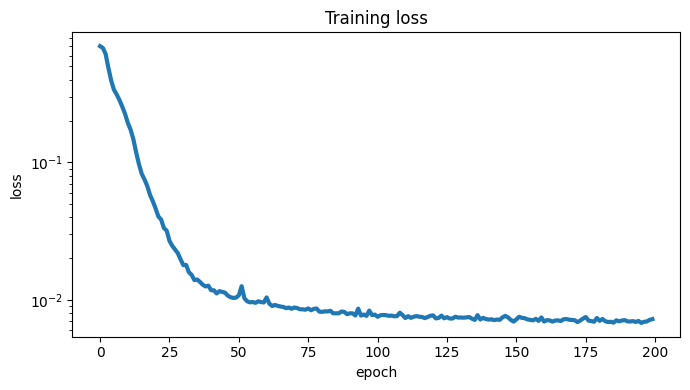

In [156]:
losses = train(model, dataset, learning_rate, num_epochs, forcing_interval, batches_per_epoch=50)
plot_losses(losses)

## Saving/Loading

In [108]:
# torch.save(model.state_dict(), f"trained_model_M{M}_P{P}_N{N}.pt")

In [ ]:
# model = ALRNN(M=M, P=P, N=N)
# model.load_state_dict(torch.load("trained_model.pt"))

## Analysis

In [ ]:
X_test_torch=torch.tensor(X_test[:]).unsqueeze(0)

T_gen = 10000 # Predicted sequence length
T_r = 1000 # Transient cutoff length
orbit = predict_free_sequence(model, X_test_torch[:,0,:],T_gen+T_r).detach().numpy()[0][T_r:,:]
plot_trajectory(orbit, X_test, T_gen)